In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sax
from simphony.quantum import QuantumSim,compose_qstate,CoherentState,SqueezedState
from functools import partial
import jax
import quantp as qp
import thewalrus as tw
from simphony.quantum import plot_quantum_result
from simphony.classical import ClassicalSim
from scipy.special import factorial
import jax.numpy as jnp
from scipy.stats import multivariate_normal
from thewalrus import _hafnian as hf
from thewalrus.quantum.conversions import Amat,Qmat

In [16]:
from gbs_func import phot_cir,trans,sub_mat

In [17]:
def one_mode_plot(mu,cov,ax,row,col):
   
    means=mu
    cov=cov

    # fig, ax = plt.subplots()
    x_max = means[0]+5
    y_max = means[1]+5
    r_max = jnp.max(jnp.array((x_max, y_max)))

    x_min = means[0]-5
    y_min = means[1]-5
    r_min = jnp.min(jnp.array((x_min, y_min)))

    x_range = (x_min, x_max)
    y_range = (y_min, y_max)
   

    # x_range = (r_min, r_max)
    # y_range = (r_min, r_max)
    n=100
    x = jnp.linspace(x_range[0], x_range[1], n)
    y = jnp.linspace(y_range[0], y_range[1], n)
    X, Y = jnp.meshgrid(x, y)
    pos = jnp.dstack((X, Y))
    dist = multivariate_normal(means, cov)
    pdf = dist.pdf(pos)
    ax[row,col].contourf(X, Y, pdf)
    ax[row,col].set_aspect("equal")
    ax[row,col].set_xlabel("X")
    ax[row,col].set_ylabel("P")
    return ax[row,col]



def mode_plot(res):
    mode=res.n_ports
    N=mode*2

    means=np.array(res.means[0])
    cov=res.cov

    u=1
    fig_ind=1
    ind=int(mode/2)
    ind=int(np.sqrt(mode))
    fig,ax=plt.subplots(ind,ind,figsize=(10,10))
    for i in range(res.n_ports):
        
        # ax=plt.subplot(ind,ind,i+1)
        mu=[means[i],means[i+N]]
        covar=np.array([[cov[u][i][i],cov[u][i][i+1]],
             [cov[u][i+1][i],cov[u][i+1][i+1]]])
        
    # Calculate row and column index
        row = i // 4
        col = i % 4
        
        one_mode_plot(mu,covar,ax,row,col)
    plt.tight_layout()
    plt.show

In [18]:
# theta_arr=np.random.rand(28)
# phi_arr=np.random.rand(28)
# theta_arr=np.multiply(theta_arr,0.5)

In [19]:
def sampler(a,b,c,wl,theta_arr=None,phi_arr=None):
       ##circuit
    if theta_arr is None  :
        theta_arr=np.zeros(len(a))
        print('theta array is None')
    if phi_arr is None:
        phi_arr=np.zeros(len(a))
        print('phi array is None')
    cir,info=sax.circuit(
        netlist={
            "instances":a,
            "connections":b,
            "ports":c
        },
        models={'SU2':partial(qp.trr)}) 
    
    su_dict={}
    i=0
    for key in range(len(a)):
        su_dict[key]={"theta":theta_arr[i],"phi":phi_arr[i]}
        i+=1
    
    val=cir(wl=wl,    S1=su_dict[0],
                      S2=su_dict[1],
                      S3=su_dict[2],
                      S4=su_dict[3],
                      S5=su_dict[4],
                      S6=su_dict[5],
                      
                      
    )
    return val


In [20]:
inst,conn,ports=phot_cir(4,4)
r=sampler(inst,conn,ports,wl=1.55)

theta array is None
phi array is None


In [21]:
U = np.array([
 [ 0.219546940711-0.256534554457j, 0.611076853957+0.524178937791j,
    -0.102700187435+0.474478834685j,-0.027250232925+0.03729094623j],
 [ 0.451281863394+0.602582912475j, 0.456952590016+0.01230749109j,
    0.131625867435-0.450417744715j, 0.035283194078-0.053244267184j],
 [ 0.038710094355+0.492715562066j,-0.019212744068-0.321842852355j,
    -0.240776471286+0.524432833034j,-0.458388143039+0.329633367819j],
 [-0.156619083736+0.224568570065j, 0.109992223305-0.163750223027j,
    -0.421179844245+0.183644837982j, 0.818769184612+0.068015658737j]
])

In [22]:
from gbs_func import clements_decomposition

def angles(U,n):
    theta_arr, phi_arr = clements_decomposition(U)
    theta_arr=np.multiply(theta_arr,(1/(2*np.pi)))
    phi_arr=np.abs(np.multiply(phi_arr,(1/(2*np.pi))))
    return theta_arr, phi_arr

In [23]:
angles(U,6)

(array([0.36579584, 0.03879647, 0.03613739, 0.05158392, 0.03672835,
        0.21509533]),
 array([0.28503469, 0.64075221, 0.8571156 , 0.8733097 , 0.75494171,
        0.1147252 ]))

Text(0.5, 0, 'wavelength (um)')

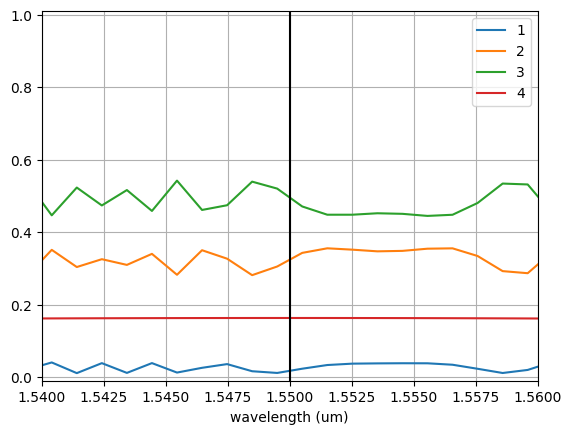

In [24]:
wl=np.linspace(1.5,1.6,100)
theta_arr,phi_arr=angles(U,6)

f=plt.figure()

# theta_arr=np.random.rand(28)
# theta_arr=np.multiply(0.5,theta_arr)
# theta_arr=np.ones(28)*0.125


sim3=ClassicalSim(ckt=sampler,wl=wl,a=inst,b=conn,c=ports,theta_arr=theta_arr,phi_arr=phi_arr)
laser_1 = sim3.add_laser(ports=["int1"], power=1.0)
laser_2 = sim3.add_laser(ports=["inb1"], power=0.0)
laser_3 = sim3.add_laser(ports=["int2"], power=0.0)
laser_4 = sim3.add_laser(ports=["inb2"], power=0.0)

detector_1 = sim3.add_detector(ports=["outt1"])
detector_2 = sim3.add_detector(ports=["outb1"])
detector_3 = sim3.add_detector(ports=["outt2"])
detector_4 = sim3.add_detector(ports=["outb2"])


result = sim3.run()   

plt.plot(wl, np.abs(result.sdict['outt1'])**2, label='1')
plt.plot(wl, np.abs(result.sdict['outb1'])**2, label='2')
plt.plot(wl, np.abs(result.sdict['outt2'])**2, label='3')
plt.plot(wl, np.abs(result.sdict['outb2'])**2, label='4')


plt.axvline(x=1.55, color='k')
plt.legend()
plt.grid()
plt.ylim([-0.01,1.01])
plt.xlim([1.49,1.61])
plt.xlim([1.54,1.56])
plt.xlabel("wavelength (um)")



 


In [25]:

mean_photon_number = 1
r = np.arcsinh(np.sqrt(mean_photon_number))
print("Sq  param: ")
print(r)

Sq  param: 
0.881373587019543


In [26]:
s_sq = np.sinh(r)**2
alpha_sq = 1 - s_sq

if alpha_sq >= 0:
    alpha = np.sqrt(alpha_sq)
else:
    alpha = None
print(alpha)


0.0


[[1.17992265 0.23903733]
 [0.23903733 0.7011752 ]]
[[0.10914315 0.34990039]
 [0.34990039 1.77195469]]
[[ 1.53250146 -0.63367025]
 [-0.63367025  0.34859638]]
[[1.21636569 0.15972141]
 [0.15972141 0.66473215]]


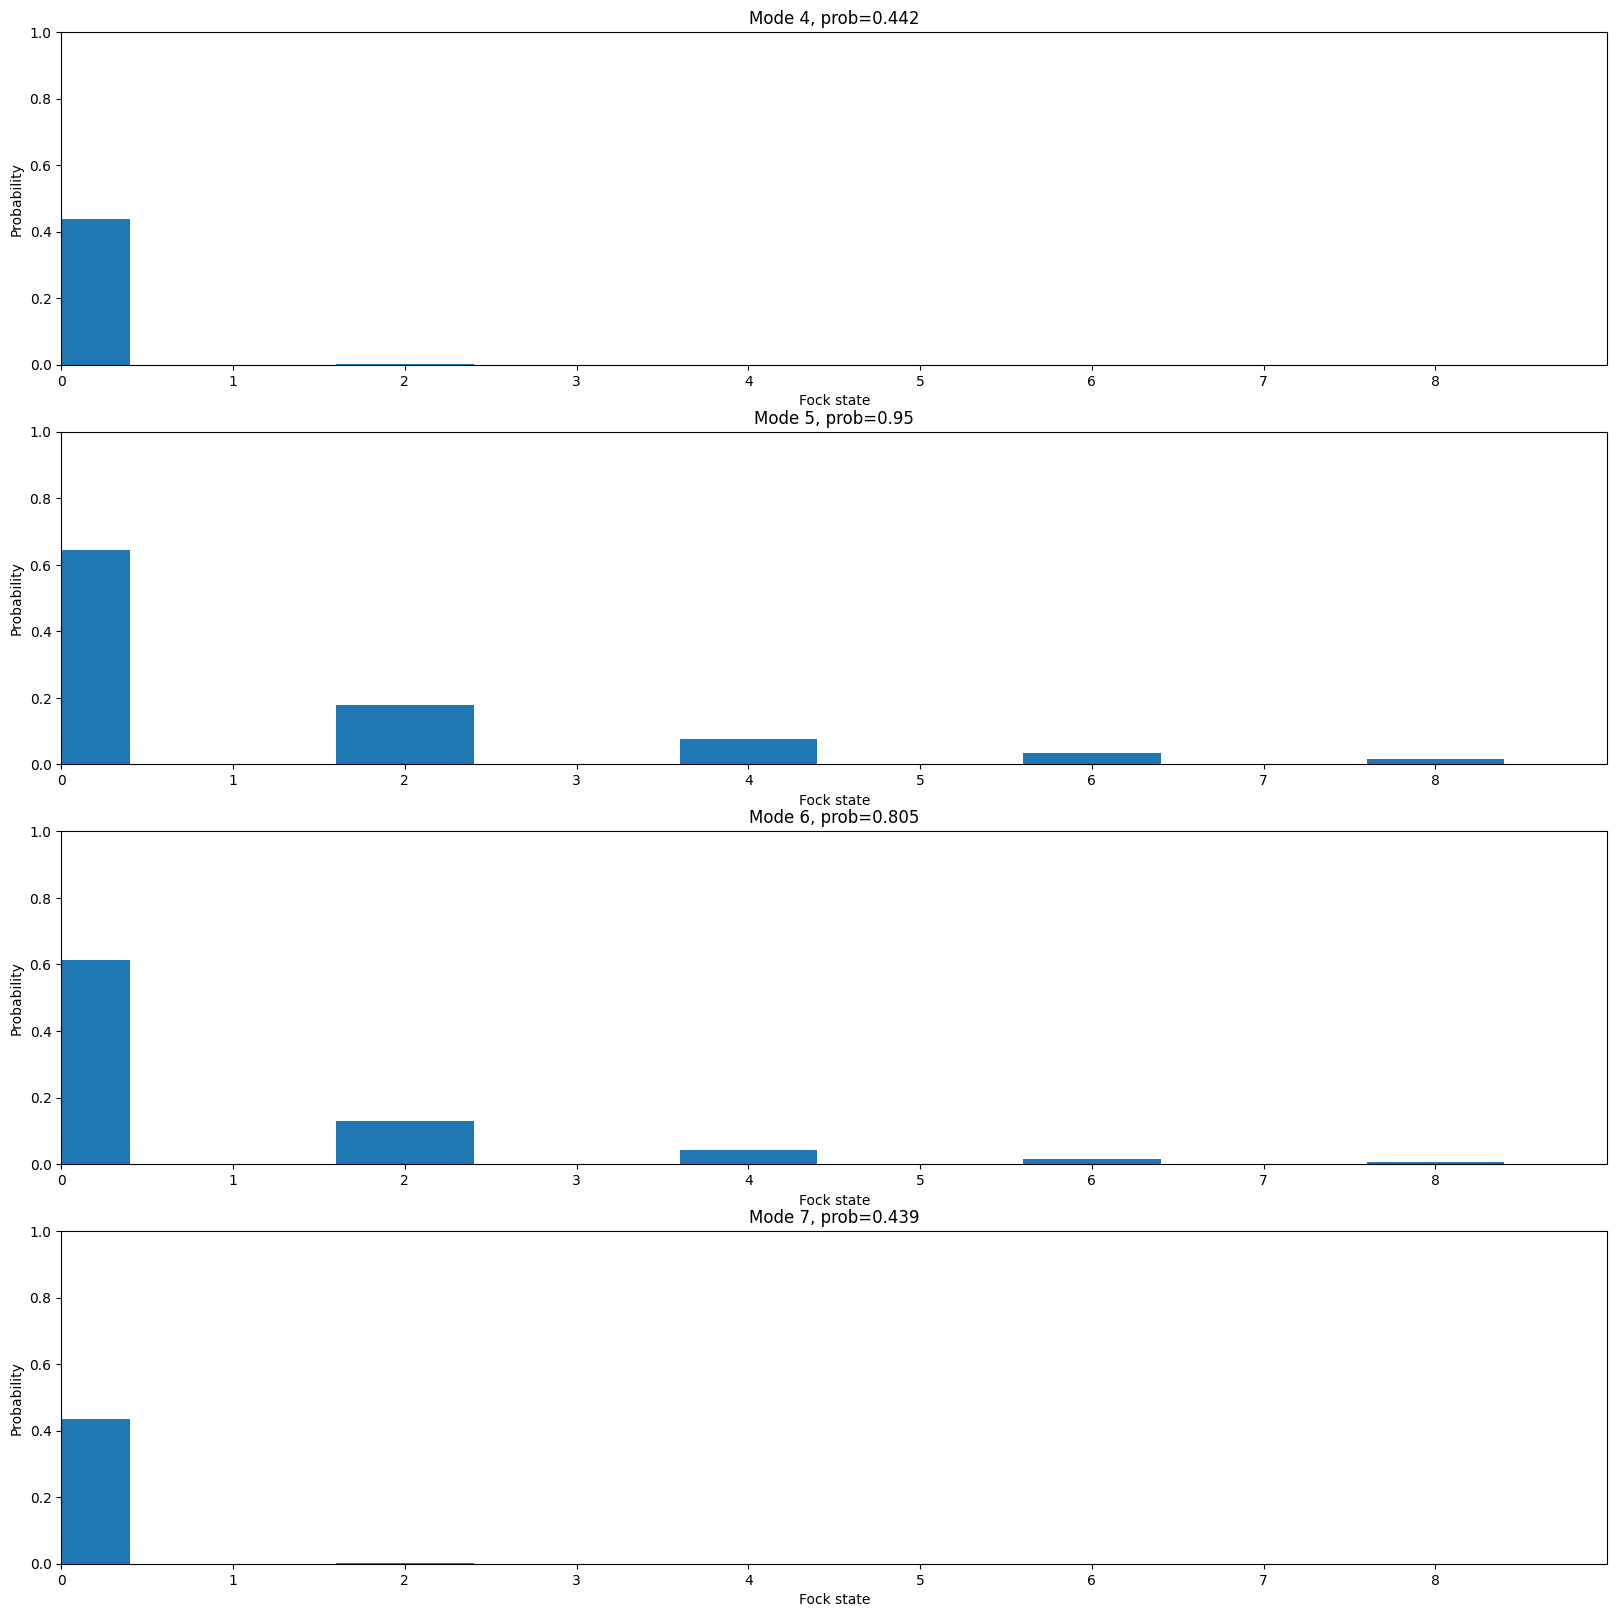

In [27]:
wl=1.55
a=0
r=0.881373587019543
r=1
# a=1.5


sim=QuantumSim(ckt=sampler,wl=wl,a=inst,b=conn,c=ports,theta_arr=theta_arr,phi_arr=phi_arr)

i1=SqueezedState(port="int1",r=r,alpha=a*np.exp(2*np.pi*0.),phi=2*np.pi*0.0)
i2=SqueezedState(port="inb1",r=r,alpha=a*np.exp(2*np.pi*0.),phi=2*np.pi*0.0)
i3=SqueezedState(port="int2",r=r,alpha=a*np.exp(2*np.pi*0.),phi=2*np.pi*0.0)
i4=SqueezedState(port="inb2",r=r,alpha=a*np.exp(2*np.pi*0.),phi=2*np.pi*0.0)

qstate=compose_qstate(i1,i2,i3,i4)
sim.add_qstate(qstate=qstate)
res=sim.run()
res_state=res.state()




fig,ax=plt.subplots(4,1,figsize=(16,16))
cutoff=9
k=0
ind=0
pdf=np.zeros((4,cutoff))
for i in range(4,8):
        means, cov = res_state.modes(i)
        print(cov)
        fock_amp = tw.quantum.state_vector(means, cov, cutoff=cutoff, hbar=1/2, check_purity=False)       

        prob=np.sum(abs(fock_amp)**2) 
        prob=round(prob,3)   
        p_arr=np.array(abs(fock_amp)**2)
       

        ax[k].bar(range(len(fock_amp)), p_arr)
        ax[k].set_xticks(range(len(fock_amp)))
        ax[k].set_xlabel("Fock state")
        ax[k].set_ylabel("Probability")
        ax[k].set_ylim([0, 1])
        ax[k].set_xlim([0, cutoff])
        ax[k].set_title(f'Mode {i}, prob={prob}')
        k+=1

# plt.tight_layout()
plt.tight_layout(pad=0.1)
plt.show()

In [28]:
res_state.modes(5)

(Array([0., 0.], dtype=float64),
 Array([[0.10914315, 0.34990039],
        [0.34990039, 1.77195469]], dtype=float64))

In [29]:
import pandas as pd
from thewalrus.quantum.conversions import Amat,Qmat
from simphony.quantum import xxpp_to_xpxp,xpxp_to_xxpp

In [30]:
means=xxpp_to_xpxp(res_state.means)[8:16]
means=xpxp_to_xxpp(means)
means

Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [31]:
Cv=res_state.cov
# cv=xpxp_to_xxpp(cv)
cv=np.array(Cv.copy())
cv=xxpp_to_xpxp(cv)
# cv[(abs(cv)) < 1e-10] = 0
# V=cv[8:16,8:16]
fd=pd.DataFrame(cv[:,4:24])
fd1=pd.DataFrame(cv[:,:8])
fd2=pd.DataFrame(cv[:,8:16])
fd3=pd.DataFrame(cv[:,16:24])
fd4=pd.DataFrame(cv[:,24:32])
fd5=pd.DataFrame(cv[:10,:10])
# print(fd1)

In [32]:
out_cov=cv[8:16,8:16]
gh=pd.DataFrame(out_cov)
gh

,0,1,2,3,4,5,6,7
0,1.179923,0.239037,-0.070579,0.008211,-0.129992,0.100695,0.530895,-0.627502
1,0.239037,0.701175,0.008211,0.070579,0.100695,0.129992,-0.627502,-0.530895
2,-0.070579,0.008211,0.109143,0.349900,0.023150,-0.016674,-0.033698,0.038315
3,0.008211,0.070579,0.349900,1.771955,-0.016674,-0.023150,0.038315,0.033698
4,-0.129992,0.100695,0.023150,-0.016674,1.532501,-0.633670,0.044227,-0.200946
5,0.100695,0.129992,-0.016674,-0.023150,-0.633670,0.348596,-0.200946,-0.044227
6,0.530895,-0.627502,-0.033698,0.038315,0.044227,-0.200946,1.216366,0.159721
7,-0.627502,-0.530895,0.038315,0.033698,-0.200946,-0.044227,0.159721,0.664732


In [33]:
hbar=1/2
new_cov=xpxp_to_xxpp(out_cov)
pd.DataFrame(new_cov)


,0,1,2,3,4,5,6,7
0,1.179923,-0.070579,-0.129992,0.530895,0.239037,0.008211,0.100695,-0.627502
1,-0.070579,0.109143,0.023150,-0.033698,0.008211,0.349900,-0.016674,0.038315
2,-0.129992,0.023150,1.532501,0.044227,0.100695,-0.016674,-0.633670,-0.200946
3,0.530895,-0.033698,0.044227,1.216366,-0.627502,0.038315,-0.200946,0.159721
4,0.239037,0.008211,0.100695,-0.627502,0.701175,0.070579,0.129992,-0.530895
5,0.008211,0.349900,-0.016674,0.038315,0.070579,1.771955,-0.023150,0.033698
6,0.100695,-0.016674,-0.633670,-0.200946,0.129992,-0.023150,0.348596,-0.044227
7,-0.627502,0.038315,-0.200946,0.159721,-0.530895,0.033698,-0.044227,0.664732


In [34]:
A=Amat(new_cov,hbar=hbar)
A[abs(A)< 1e-10]=0
df=pd.DataFrame(A)
df


,0,1,2,3,4,5,6,7
0,0.201062-0.200779j,-0.059283-0.006897j,-0.109186-0.084578j,0.445924+0.527069j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
1,-0.059283-0.006897j,-0.698338-0.293898j,0.019445+0.014005j,-0.028305-0.032183j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
2,-0.109186-0.084578j,0.019445+0.014005j,0.497210+0.532250j,0.037148+0.168784j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,0.445924+0.527069j,-0.028305-0.032183j,0.037148+0.168784j,0.231672-0.134158j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
4,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.201062+0.200779j,-0.059283+0.006897j,-0.109186+0.084578j,0.445924-0.527069j
5,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.059283+0.006897j,-0.698338+0.293898j,0.019445-0.014005j,-0.028305+0.032183j
6,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.109186+0.084578j,0.019445-0.014005j,0.497210-0.532250j,0.037148-0.168784j
7,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.445924-0.527069j,-0.028305+0.032183j,0.037148-0.168784j,0.231672+0.134158j


In [35]:
from thewalrus import decompositions as dc
def decompose_cov(cov):
    cov=np.abs(cov)
    m = cov.shape[0] // 2
    D, S = dc.williamson(cov)
    T = S @ S.T 
    DmI = D - np.eye(2*m)
    DmI[abs(DmI) < 1e-11] = 0. # remove slightly negative values
    sqrtW = S @ np.sqrt(DmI)
    return T, sqrtW

In [62]:
1/(np.cosh(0.881373587019543)**4)
1/(np.cosh(1)**4)

0.1763784476141347

In [37]:
# def sigma(cov):
#     n=len(cov)//2
#     I=np.identity(n,dtype=complex)
#     iI=(1j)*I
#     f=np.block([[I,iI],[I,-iI]])
#     f=(1/np.sqrt(2))*f
#     sigma=f@cov@((f.conj()).T)
#     return sigma

# def xmat(N):
#     I = np.identity(N)
#     O = np.zeros_like(I)
#     X = np.block([[O, I], [I, O]])
#     return X


# def qmat(cov,hbar=hbar):
#     # qmat=np.ones((len(cov),len(cov)))*0.5
#     qmat=np.eye(len(cov))*0.5
#     q=cov+qmat
#     return q

# def amat(cov,hbar=hbar):
#     N = len(cov) // 2
#     X = xmat(N)

#     # inverse Q matrix
    
#     Q = qmat(cov, hbar=hbar)

#     Qinv = np.linalg.inv(Q)

#     # calculate Hamilton's A matrix: A = X.(I-Q^{-1})*
   
#     I=np.eye(len(cov))
#     i_minus_sigma_inv=I-Qinv
#     # A =np.dot(X,i_minus_sigma).conj()f@cov@((f.conj()).T)
#     A = X @ (np.identity(2 * N) - Qinv)
#     # A = X @(i_minus_sigma_inv)
#     return A

In [38]:
# sigma_cov=sigma(new_cov)
# q=qmat(sigma_cov)
# det=np.linalg.det(q)
# 1/np.sqrt(np.abs(det))
# # qq=np.linalg.inv(q)
# a=amat(sigma_cov)
# a[np.abs(a)<1e-10]=0
# pd.DataFrame(a)

# def F(cov):
#     n=len(cov)//2
#     I=np.identity(n,dtype=complex)
#     iI=(1j)*I
#     f=np.block([[I,iI],[I,-iI]])
#     f=(1/np.sqrt(2))*f   
#     return f
# mean=means
# f=F(mean)
# new_mean=f@mean
# s=sigma(new_cov)
# pd.DataFrame(s)

In [39]:
from thewalrus.quantum.conversions import Amat,Qmat

In [40]:
A=Amat(new_cov,hbar=hbar)
Q=Qmat(new_cov,hbar=hbar)
# Q=qmat(s)
# A=amat(s)
Q_inv=np.linalg.inv(Q)
# Q=qmat(s)
# A=amat(s)
Det=np.linalg.det(Q)
1/np.sqrt(np.abs(Det))

0.1763784476141329

In [115]:
from thewalrus import hafnian as haf
def probability(A,ar,det):
    fact=1
    for factor in ar:
        fact*=factorial(factor)      
    As=sub_mat(A,ar)
    hafn=haf(As)
    if hafn.real <0:
        if hafn.imag<0:
            hafn=0
    det=det
    prob=hafn/(det*fact)
    return prob.real

In [42]:
df

,0,1,2,3,4,5,6,7
0,0.201062-0.200779j,-0.059283-0.006897j,-0.109186-0.084578j,0.445924+0.527069j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
1,-0.059283-0.006897j,-0.698338-0.293898j,0.019445+0.014005j,-0.028305-0.032183j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
2,-0.109186-0.084578j,0.019445+0.014005j,0.497210+0.532250j,0.037148+0.168784j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,0.445924+0.527069j,-0.028305-0.032183j,0.037148+0.168784j,0.231672-0.134158j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
4,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.201062+0.200779j,-0.059283+0.006897j,-0.109186+0.084578j,0.445924-0.527069j
5,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.059283+0.006897j,-0.698338+0.293898j,0.019445-0.014005j,-0.028305+0.032183j
6,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.109186+0.084578j,0.019445-0.014005j,0.497210-0.532250j,0.037148-0.168784j
7,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.445924-0.527069j,-0.028305+0.032183j,0.037148-0.168784j,0.231672+0.134158j


In [63]:
hbar=1/2
A=Amat(new_cov,hbar=hbar)
Q=Qmat(new_cov,hbar=hbar)
det=(np.sqrt(np.linalg.det(Q)))
d=1/det
d


(0.1763784476141329-2.594882124616612e-17j)

In [44]:
B = (np.dot(U, U.T) * np.tanh(1))[:, [0, 1]][[0, 1]]
pd.DataFrame(B)
abs(haf(B))**2/det


(0.06855956371214471-1.0086492355197647e-17j)

In [70]:
ar=[3,0,0,0]
new_a=sub_mat(A,ar)
h=haf(new_a)
hh=h/det
abs(hh)
h


(-4.879379027172531e-16-1.5959455978986625e-16j)

In [71]:
new_a[abs(new_a)<1e-10]=0
pd.DataFrame(new_a)

,0,1,2,3,4,5
0,0.201062-0.200779j,0.201062-0.200779j,0.201062-0.200779j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
1,0.201062-0.200779j,0.201062-0.200779j,0.201062-0.200779j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
2,0.201062-0.200779j,0.201062-0.200779j,0.201062-0.200779j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.201062+0.200779j,0.201062+0.200779j,0.201062+0.200779j
4,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.201062+0.200779j,0.201062+0.200779j,0.201062+0.200779j
5,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.201062+0.200779j,0.201062+0.200779j,0.201062+0.200779j


In [72]:
A=Amat(new_cov,hbar=hbar)
Q=Qmat(new_cov,hbar=hbar)
det=np.abs(np.sqrt(np.linalg.det(Q)))
d=1/det
d
# ar=[1,1,1,1]
probability(A,ar,det)

0.0

In [48]:
def is_symmetric(matrix):
    return np.allclose(matrix, matrix.T)

is_symmetric(A)

True

In [49]:

def trans(A,arr):
    
    sum=np.sum(arr)
    D=np.eye(int(sum),dtype=complex)
    j=0
    d=0 
    for a in arr:   
        if a==0:
            j+=1
        else:
            one=np.ones((a,a),dtype=complex)*A[j,j]
            D[d:d+a,d:d+a]=one
            d+=a
            j+=1

    new_dict={}
    for (i, j), value in np.ndenumerate(A):
        new_dict[(value.real,value.imag)]=[i,j]
    

    new_mat=D.copy()
    for (i, j), value in np.ndenumerate(D):
        if value==0*(1+1j):
            
            a=D[i,i]
            b=D[j,j]
            a_ind = new_dict[(a.real,a.imag)]
            b_ind = new_dict[(b.real,b.imag)]
        
            for key, (d_i, d_j) in new_dict.items():
                if (d_i, d_j) == (a_ind[0], b_ind[0]):
                    
                    new_mat[i, j] = key[0]+1j*key[1]

    return new_mat

## repearing for first and fourth quad
def sub_mat(mat,arr):
    n=int(mat.shape[0]/2)
    A=mat[:n,:n]
    B=mat[:n,n:]
    C=mat[n:,n:]

    a_new=trans(A,arr)
    b_new=trans(B,arr)
    c_new=trans(C,arr)

    
    s=a_new.shape[0]
    As=np.eye(2*s,dtype=complex)
    As[:s,:s]=a_new
    As[s:,:s]=b_new
    As[:s,s:]=b_new.T
    As[s:,s:]=c_new
    return As

In [76]:
m=4
array=range(12)
perm_mat=[]
new_array=[]


for i in array:
    new_array.append([i])


for _ in range(3):
    inter=[]
    for n in new_array:
        for i in array:      
        
            N=n.copy()
            N.append(i)
            inter.append(N)

    new_array=inter

new_array_1=[]
for n in new_array:
    # if np.sum(n)>max(array):
    if np.sum(n)>10:
        None
    else:
        new_array_1.append(n)

new_array_1
len(new_array_1)

1816

In [51]:
# new_array_1

In [77]:
# possibilities=perm_mat

possibilities=new_array_1
probability_mat=[]
for poss in possibilities:
    try:
         pro=probability(A,poss,det)
    except:
            print(poss)
    probability_mat.append(pro)


np.sum(probability_mat)


0.9106716000765812

In [95]:
probability_mat[1]
new_array_1[1]
pp=[1,2,3,4]
tuple(pp)

(1, 2, 3, 4)

In [96]:
max(probability_mat)
info_dict={}
for i in range(len(new_array_1)):
    info_dict[probability_mat[i]]=[]
    info_dict[probability_mat[i]].append(new_array_1[i])

info_dict_inv={}
for i in range(len(new_array_1)):
    info_dict_inv[tuple(new_array_1[i])]=[]
    info_dict_inv[tuple(new_array_1[i])].append(probability_mat[i])

In [102]:
info_dict[max(probability_mat)]
tup=[1,2,0,4]
info_dict_inv[tuple(tup)]


[7.486012998657169e-17]

In [103]:
dont_del=probability_mat
np.sum(probability_mat)

0.9106716000765812

In [55]:
prr=dont_del

In [57]:
## loop for each photon value,
#loop for each specific permutation for each value
#compute hafnina
# store prob


In [58]:
from thewalrus import perm

In [121]:
c_ar=[0,2,4,6,8]
c_ar=[0,2,4]
c_ar=range(10)
p_dict={}
perm_dict={}
perm_mat=[[]]

prev_prob=[1]
ar=[]
# for m in range(len(c_ar)-1):
for m in range(4):
   
    A=Amat(new_cov,hbar=hbar)
    Q=Qmat(new_cov,hbar=hbar)
    dt=np.linalg.det(Q)
    det=1/(np.sqrt(np.abs(dt)))

    next_mat=[]
    inter_prob=[]
    pind=0
    prob_mat=[]
    for perm in perm_mat:       
        
        for a in c_ar:         
            ar=perm.copy()
            ar.append(a) 

            if np.sum(ar)>10:
                break
            # elif m==max(range(8)):
                
            #     if np.sum(ar)!=8:
            #         None
            #     else:
            #         fact=1
            #         for factor in ar:
            #             fact=fact*factorial(factor)      
            #         As=sub_mat(A,ar)
            #         haf=hf._haf(As)
            #         prob=haf/(det*fact)
            #         prob=prob/prev_prob[pind]
                    
            #         prob_mat.append(prob.real)


            #         inter_prob.append(prob)         
            #         next_mat.append(ar)
            else:
                fact=1
                for factor in ar:
                    fact=fact*factorial(factor)      
                As=sub_mat(A,ar)
                hafn=haf(As)
                prob=abs(hafn)*det/fact
                if abs(prob)<1e-10:
                    prob=0
                elif prev_prob[pind]==0:
                    prob=0
                else:
                    prob=prob/prev_prob[pind]
                
                prob_mat.append(prob.real)


                inter_prob.append(prob)         
                next_mat.append(ar)

        pind+=1
    prev_prob=inter_prob
    perm_mat=next_mat

In [123]:
sum(prev_prob)

393.8952659483182

In [ ]:
prob_mat/np.sum(prob_mat)

In [ ]:

# len(perm_mat)
# pind
# # inter_prob
# # # max(range(7))
# len(prob_mat)
